##### Copyright 2020 The TensorFlow Authors.

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [2]:
CALC_DEVICE = "gpu"
DEVICE_ID = "0" if CALC_DEVICE == "gpu" else "-1"
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE_ID
if os.environ["CUDA_VISIBLE_DEVICES"] != "-1":
    tf.keras.backend.set_floatx("float32")
    physical_devices = tf.config.list_physical_devices("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    # tf.config.run_functions_eagerly(True)
else:
    print("*** cpuで計算します ***")
    # なんか下のやつ使えなくなっている、、
    tf.config.run_functions_eagerly(True)

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [5]:
train_size = 60000
batch_size = 32
test_size = 10000

## Use *tf.data* to batch and shuffle the data

In [6]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [7]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [9]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [10]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [11]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -157.01844787597656, time elapse for current epoch: 4.569483041763306


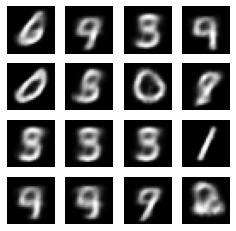

In [12]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [14]:
# encoder info
model.encoder.summary()
# decoder info
model.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 9220      
Total params: 28,036
Trainable params: 28,036
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)              4704      
______________________________

### Display a generated image from the last training epoch

In [14]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

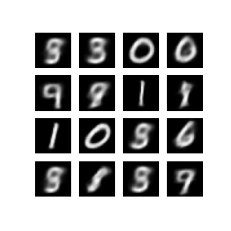

In [15]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [16]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


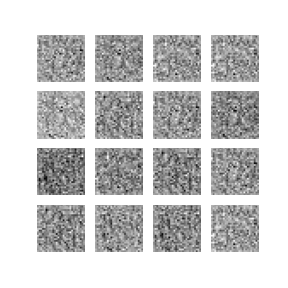

In [17]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [18]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

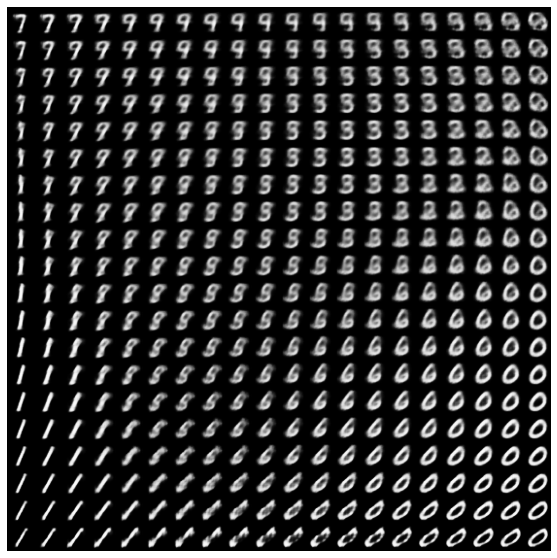

In [19]:
plot_latent_images(model, 20)

## Next steps

This tutorial has demonstrated how to implement a convolutional variational autoencoder using TensorFlow. 

As a next step, you could try to improve the model output by increasing the network size. 
For instance, you could try setting the `filter` parameters for each of the `Conv2D` and `Conv2DTranspose` layers to 512. 
Note that in order to generate the final 2D latent image plot, you would need to keep `latent_dim` to 2. Also, the training time would increase as the network size increases.

You could also try implementing a VAE using a different dataset, such as CIFAR-10.

VAEs can be implemented in several different styles and of varying complexity. You can find additional implementations in the following sources:
- [Variational AutoEncoder (keras.io)](https://keras.io/examples/generative/vae/)
- [VAE example from "Writing custom layers and models" guide (tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP Probabilistic Layers: Variational Auto Encoder](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

If you'd like to learn more about the details of VAEs, please refer to [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691).

In [1]:
import os
import sys

from rich import print
from tensorflow.python.keras.metrics import accuracy

from nn.wandb_classification_callback import WandbClassificationCallback

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import datetime
from collections import Counter
from typing import Any, Dict, List

import tensorflow as tf
import wandb
import numpy as np

from data_analysis.py_color import PyColor
from data_analysis.utils import Utils
from nn.losses import EDLLoss
from nn.model_base import VDANN

# from nn.metrics import CategoricalTruePositives
from pre_process.pre_process import PreProcess
from pre_process.record import Record
import random

# from wandb.keras import WandbCallback

In [2]:
def set_seed(seed=200):
    tf.random.set_seed(seed)
    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
# 環境設定
set_seed()
CALC_DEVICE = "gpu"
DEVICE_ID = "0" if CALC_DEVICE == "gpu" else "-1"
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE_ID
if os.environ["CUDA_VISIBLE_DEVICES"] != "-1":
    tf.keras.backend.set_floatx("float32")
    physical_devices = tf.config.list_physical_devices("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    # tf.config.run_functions_eagerly(True)
else:
    print("*** cpuで計算します ***")
    # なんか下のやつ使えなくなっている、、
    tf.config.run_functions_eagerly(True)

# ハイパーパラメータの設定
TEST_RUN = False
EPOCHS = 10
HAS_ATTENTION = True
PSE_DATA = False
HAS_INCEPTION = True
IS_PREVIOUS = False
IS_NORMAL = True
HAS_DROPOUT = True
IS_ENN = False
# FIXME: 多層化はとりあえずいらない
IS_MUL_LAYER = True
HAS_NREM2_BIAS = False
HAS_REM_BIAS = False
DROPOUT_RATE = 0.2
BATCH_SIZE = 64
N_CLASS = 5
# KERNEL_SIZE = 512
# KERNEL_SIZE = 256
KERNEL_SIZE = 128
STRIDE = 16
# STRIDE = 16
SAMPLE_SIZE = 10000
DATA_TYPE = "spectrogram"
FIT_POS = "middle"
CLEANSING_TYPE = "no_cleansing"
NORMAL_TAG = "normal" if IS_NORMAL else "sas"
ATTENTION_TAG = "attention" if HAS_ATTENTION else "no-attention"
PSE_DATA_TAG = "psedata" if PSE_DATA else "sleepdata"
INCEPTION_TAG = "inception" if HAS_INCEPTION else "no-inception"
WANDB_PROJECT = "test" if TEST_RUN else "1215_test"
# WANDB_PROJECT = "test" if TEST_RUN else "base_learning_20211109"
ENN_TAG = "enn" if IS_ENN else "dnn"
INCEPTION_TAG += "v2" if IS_MUL_LAYER else ""

In [4]:
# オブジェクトの作成
pre_process = PreProcess(
    data_type=DATA_TYPE,
    fit_pos=FIT_POS,
    verbose=0,
    kernel_size=KERNEL_SIZE,
    is_previous=IS_PREVIOUS,
    stride=STRIDE,
    is_normal=IS_NORMAL,
    has_nrem2_bias=HAS_NREM2_BIAS,
    has_rem_bias=HAS_REM_BIAS,
    model_type=ENN_TAG,
    cleansing_type=CLEANSING_TYPE,
)
# 記録用のjsonファイルを読み込む
MI = pre_process.my_env.mi
datasets = pre_process.load_sleep_data.load_data(
    load_all=True,
    pse_data=PSE_DATA,
)

*** すべての被験者を読み込みます（load_dataの引数:nameは無視します） ***
 140703_Li を読み込みます 
 140711_Yamamoto を読み込みます 
 140819_Kumazawa を読み込みます 
 140820_Yasuda を読み込みます 
 140821_Murakami を読み込みます 
 140823_Murakami を読み込みます 
 140825_Kashiwazaki を読み込みます 
 140826_Ootsuji を読み込みます 
 140828_Otsuji を読み込みます 
 140830_Murakami を読み込みます 
 140922_Kumazawa_M を読み込みます 
 140925_Kashiwazaki を読み込みます 
 140929_Kumazawa を読み込みます 
 140930_Hayashi を読み込みます 
 141001_Hayashi を読み込みます 
 141002_Hayashi を読み込みます 
 141003_Kashiwazaki_F を読み込みます 
 141006_Hiromoto を読み込みます 
 141014_Kumazawa_F を読み込みます 
 141015_Hiromoto を読み込みます 
 141024_Kawasaki_F を読み込みます 
 141027_Kawasaki を読み込みます 
 141029_Umezawa を読み込みます 
 141030_Kumazawa を読み込みます 
 141104_Takadama を読み込みます 
 141124_Murata を読み込みます 
 141127_Tatsumi を読み込みます 
 141128_Sato_Minato を読み込みます 
 141204_Tatebe を読み込みます 
 141205_Fujitsuka を読み込みます 
 141217_Sugimoto を読み込みます 
 141219_Usui を読み込みます 
 151104_Nagae を読み込みます 
 151105_Nagae を読み込みます 
 151106_Nagae を読み込みます 
 151111_Kawasaki を読み込みます 
 151112_Kawasaki を読み込みます 
 1

In [5]:
# モデルのidを記録するためのリスト
test_id = 0
test_name = pre_process.name_list[0]
date_id_saving_list = list()
date_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
date_id_saving_list.append(date_id)
(train, test) = pre_process.split_train_test_from_records(
    datasets, test_id=test_id, pse_data=PSE_DATA
)

In [6]:
# データセットの作成
(x_train, y_train), (x_test, y_test) = pre_process.make_dataset(
    train=train,
    test=test,
    is_storchastic=False,
    pse_data=False,
    to_one_hot_vector=False,
    each_data_size=SAMPLE_SIZE,
)
traindata = tf.data.Dataset.from_tensor_slices(
    (x_train.astype("float32"), y_train.T)
)
traindata = traindata.shuffle(buffer_size=x_train.shape[0]).batch(
    BATCH_SIZE
)
testdata = tf.data.Dataset.from_tensor_slices(
    (x_test.astype("float32"), y_test.T)
)
testdata = testdata.shuffle(buffer_size=x_test.shape[0]).batch(BATCH_SIZE)
# データセットの数を表示
print(f"training data : {x_train.shape}")
ss_train_dict = Counter(y_train[0])
ss_test_dict = Counter(y_test[0])


shape = (64, 30, 1)
inputs = tf.keras.Input(shape=shape)


model = VDANN(
    inputs=inputs,
    gamma=0,
    latent_dim=6,
    alpha=1,
    beta=0,
    target_dim=5,
    subject_dim=68,
    has_inception=True,
    has_attention=True,
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
)

# tensorboard作成
log_dir = os.path.join(
    pre_process.my_env.project_dir, "vdann", test_name, date_id
)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tf_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1
)

# train_losses = list()
# test_losses = list()

tensor2numpy = lambda x: x.numpy()
for epoch in range(EPOCHS):
    print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(traindata):
        train_loss = model.train_step(x_batch_train)
        if step % 50 == 0:
            print(
                f"train loss: (vae, sbj, tar) =  {tuple(map(tensor2numpy, train_loss))}"
            )
    # train_losses.append(train_loss)
    print(f"train loss: {train_loss}")
    # train_metrics.reset_states()

    for step, x_batch_test in enumerate(testdata):
        test_loss = model.test_step(x_batch_test)
    print(
        f"test loss: (vae, sbj, tar) = {tuple(map(tensor2numpy, test_loss))}"
    )
    # test_losses.append(test_loss)
    # test_metrics.reset_states()

# tensorboardのログ
# if log_tf_projector:
#     utils.make_tf_projector(x=x_test, y=y_test, batch_size=batch_size, hidden_layer_id=-7, log_dir=log_dir, data_type=data_type, model=model)



- 訓練データのサイズを揃えます
訓練データの各睡眠段階（補正前） Counter({2.0: 27251, 4.0: 11395, 5.0: 8535, 3.0: 6609, 1: 1872, 0: 64})
訓練データの各睡眠段階（補正後） {1: 10000, 2: 10000, 3: 10000, 4: 10000, 5: 10000}
- 訓練データをシャッフルします
- noneの処理を行います
- max正規化を行います
- チャンネル方向に軸を追加します
*** 全ての前処理後（one-hotを除く）の訓練データセット（確認用） *** 
 Counter({4: 10000, 2: 10000, 1: 10000, 3: 10000, 0: 10000})


training data : (50000, 64, 30, 1)

Start of epoch 0

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5889819)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6067849)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5583959)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6020631)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5160277)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5794389)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5856521)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5521677)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5217712)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5957899)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5738724)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5528054)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6109254)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6422999)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4935367)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5914292)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.4621278>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.6067139)

Start of epoch 1

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5240068)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5701486)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5719192)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5528759)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5582979)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6058061)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5924563)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5236005)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5671563)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5856549)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6105968)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5337943)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5614088)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6087967)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.584209)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5444427)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5338717>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.6098003)

Start of epoch 2

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5629005)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5928829)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5398853)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.559572)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5609679)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5587063)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5126532)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6203048)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5089525)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5799825)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.53951)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5842386)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5545161)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.525471)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.543006)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.7551761)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5482152>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.6107203)

Start of epoch 3

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5208827)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5525863)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5387919)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5487944)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6016674)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5916624)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5123508)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6165218)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4319986)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4817462)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5319319)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4633622)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.510196)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.568196)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4866552)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5257316)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.6265423>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.5006572)

Start of epoch 4

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4811184)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4709976)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5864348)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5532874)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5750346)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5541972)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4943976)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4353187)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.52647)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.551937)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5601454)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6087997)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5639169)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5373209)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4889953)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5085347)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.4914056>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.6184117)

Start of epoch 5

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5206513)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5898268)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5356112)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5649145)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5428655)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5301299)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.527716)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5710087)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5657078)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6619922)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5109687)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5789788)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5275092)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.532157)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5347817)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.3537993)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.4593569>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.341727)

Start of epoch 6

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5075419)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5055217)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.569814)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4718571)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.558214)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4712582)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4193833)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5643121)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.538306)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.539137)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4960622)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5673406)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6106633)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5278928)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5909083)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4993379)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5549011>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.4644203)

Start of epoch 7

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5442057)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5946286)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5838313)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4821563)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5616609)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.541059)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5885223)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.6329986)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4637535)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4266925)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5336192)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4923917)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5704322)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.543761)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4199129)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.516933)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.609438>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.451297)

Start of epoch 8

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5655172)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4858623)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5789633)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5650586)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5037138)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4742217)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5737118)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4522405)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4380448)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4828149)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.537261)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.3961681)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5220723)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4808831)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5078046)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4855385)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5875301>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.4785358)

Start of epoch 9

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5444608)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5258749)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5590602)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4706335)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5316296)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.493145)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.473558)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5528209)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.5269907)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.4917979)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.609438)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.609438)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.609438)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.609438)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.609438)

train loss: (vae, sbj, tar) =  (0.0, 0.0, 1.609438)

train loss: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), 
dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.609438>)

test loss: (vae, sbj, tar) = (0.0, 0.0, 1.609438)

In [25]:

# encode spectrogram
mean, log_var = tf.split(model.encoder.predict(x=x_train, batch_size = BATCH_SIZE), num_or_size_splits=2, axis=1)
# latent space z
z = model.sample(inputs=(mean, log_var))
# target outputs
y_pred = model.tar_classifier.predict(z, batch_size = BATCH_SIZE)
y_pred = np.argmax(y_pred, axis=1)

(50000,)

In [12]:

print(PyColor().GREEN_FLASH, "モデルを保存します ...", PyColor().END)
# エンコーダの保存
path = os.path.join(pre_process.my_env.models_dir, test_name, date_id, "encoder")
if not os.path.exists(path):
    os.makedirs(path)
model.encoder.save(path)
# 分類器の保存
path = os.path.join(pre_process.my_env.models_dir, test_name, date_id, "decoder")
if not os.path.exists(path):
    os.makedirs(path)
model.tar_classifier.save(path)

[05;32m モデルを保存します ... [0m

INFO:tensorflow:Assets written to: /home/takadamalab/taiki_senju/sleep_study/models/140703_Li/20211226-234303/encoder/assets
INFO:tensorflow:Assets written to: /home/takadamalab/taiki_senju/sleep_study/models/140703_Li/20211226-234303/decoder/assets


In [ ]:

print(PyColor().GREEN_FLASH, "モデルを保存します ...", PyColor().END)
path = os.path.join(pre_process.my_env.models_dir, test_name, date_id)
# model.save(path)

In [61]:
# train用
# mean, logvar = tf.split(model.encoder(x_train[:200]), num_or_size_splits=2, axis=1)
# z = tf.exp(logvar * 0.5) + mean
# test用
mean, logvar = tf.split(model.encoder(x_test), num_or_size_splits=2, axis=1)
z = tf.exp(logvar * 0.5) + mean

In [62]:
# train用
# y_train_trimed = y_train[0][:200]
# test用
y_train_trimed = y_test[0]

In [63]:
nr34 = z[y_train_trimed == 0]
nr2 = z[y_train_trimed == 1]
nr1 = z[y_train_trimed == 2]
rem = z[y_train_trimed == 3]
wake = z[y_train_trimed == 4]

No handles with labels found to put in legend.


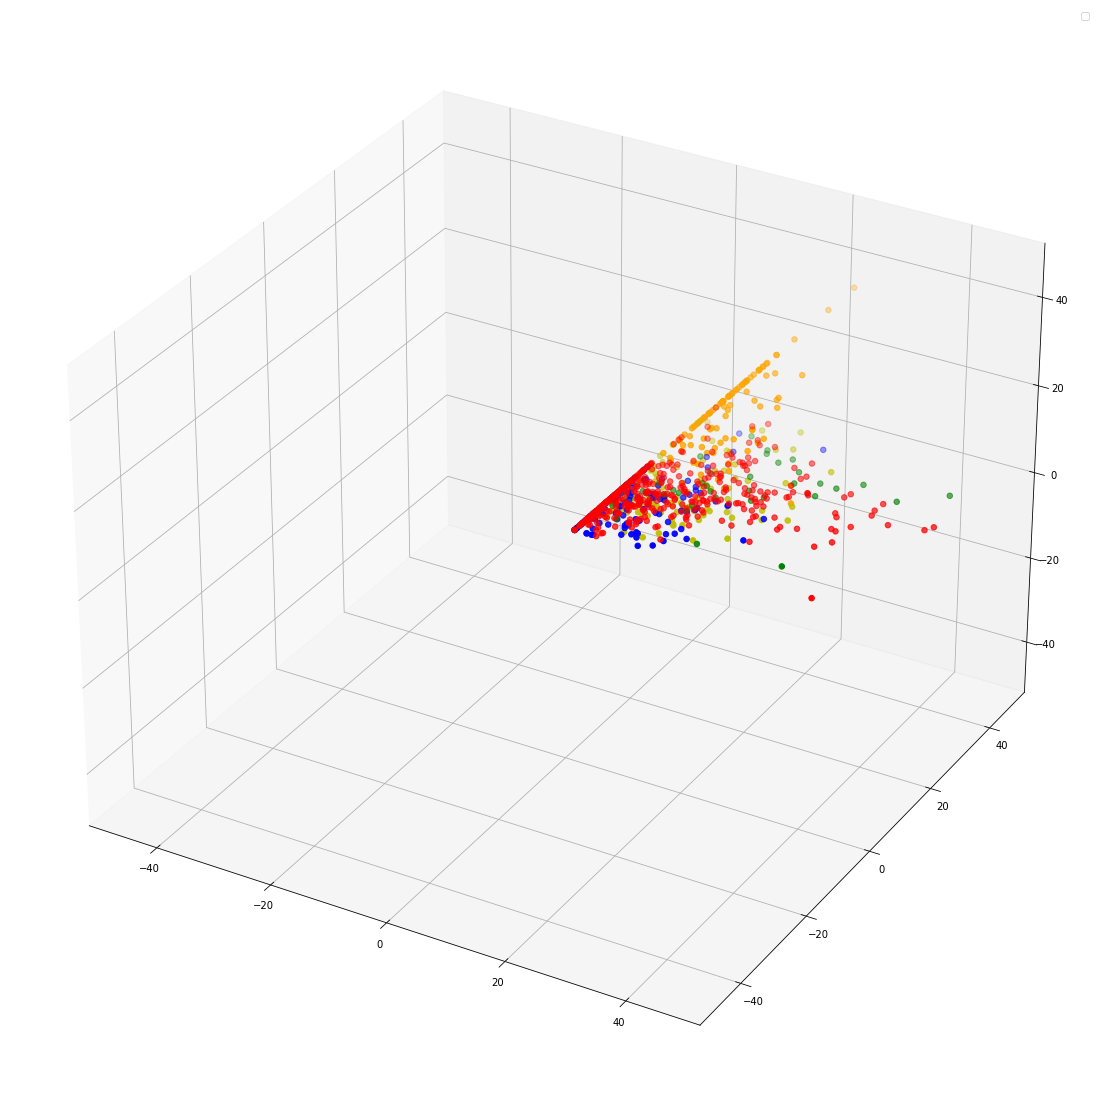

In [64]:
%matplotlib inline
from numpy.random import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
rcParams['figure.figsize'] = 20,20

#グラフをプロット
fig = plt.figure()
# ax0 = fig.add_subplot(221, projection='3d')
# ax0.set_xlim([-50,50])
# ax0.set_ylim([-50,50])
# ax0.set_zlim([-50,50])
# ax0.scatter(v[:,0], values1[:,1], values1[:,2], s=10, alpha=0.1, c='b')
# ax0.legend()
#パラメータをいじってみる
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlim([-50,50])
ax1.set_ylim([-50,50])
ax1.set_zlim([-50,50])
ax1.scatter(nr34[:,0], nr34[:,1], nr34[:,2], s=30, c='b')
ax1.scatter(nr2[:,0], nr2[:,1], nr2[:,2], s=30, c='r')
ax1.scatter(nr1[:,0], nr1[:,1], nr1[:,2], s=30, c='g')
ax1.scatter(rem[:,0], rem[:,1], rem[:,2], s=30, c='y')
ax1.scatter(wake[:,0], wake[:,1], wake[:,2], s=30, c='orange')
ax1.legend()
plt.savefig("tmp.png")

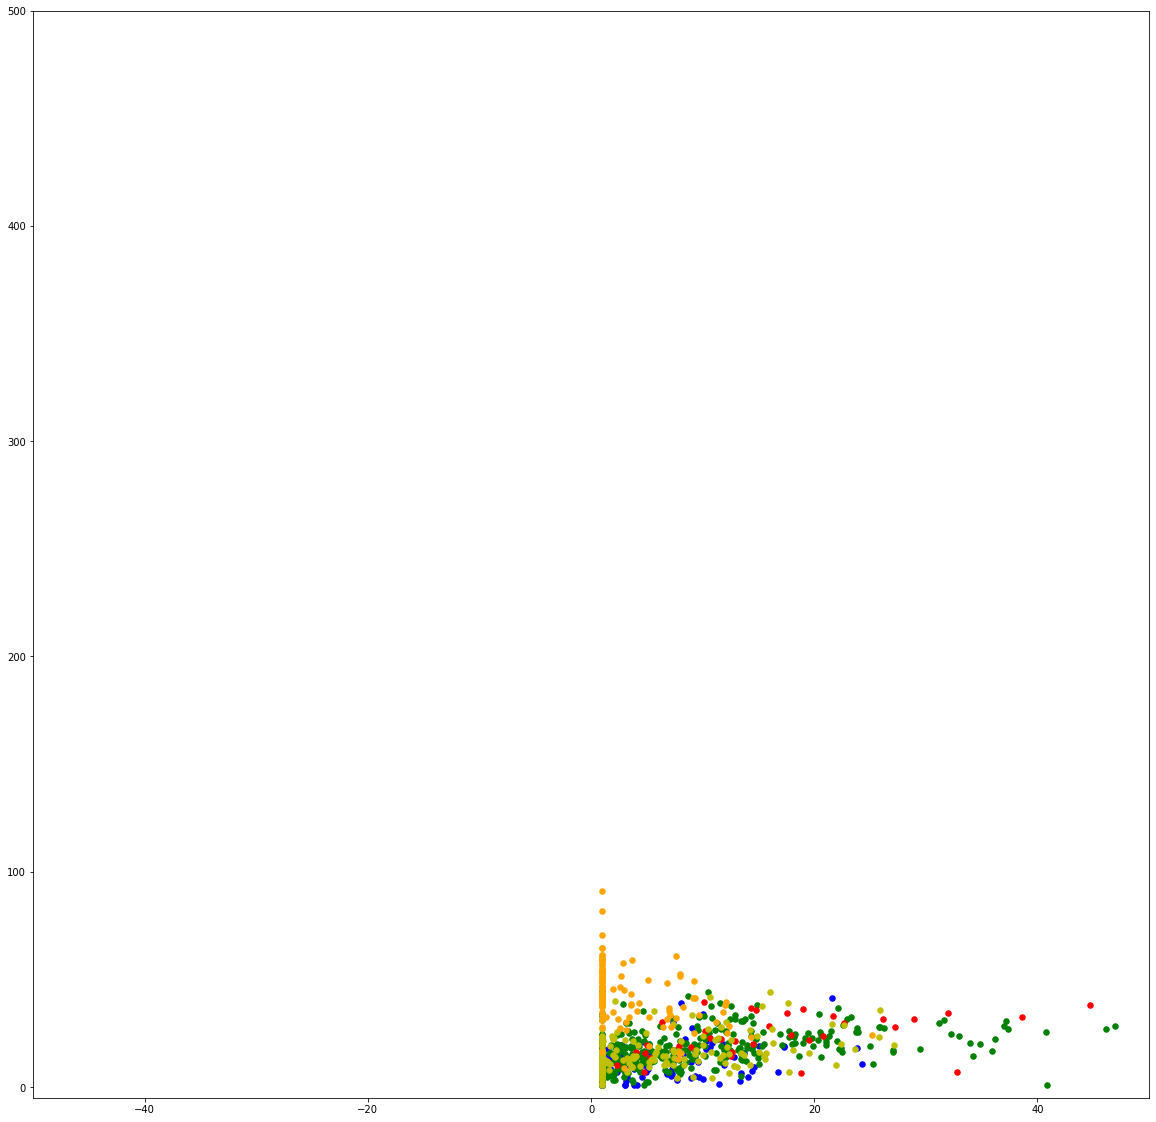

In [65]:
plt.scatter(nr34[:, 0], nr34[:,1], s=30, c='b')
plt.scatter(nr2[:, 0], nr2[:,1], s=30, c='g')
plt.scatter(nr1[:, 0], nr1[:,1], s=30, c='r')
plt.scatter(rem[:, 0], rem[:,1], s=30, c='y')
plt.scatter(wake[:, 0], wake[:,1], s=30, c='orange')
plt.xlim([-50,50])
plt.ylim([-5,500])
plt.savefig("2d_png.png")

In [66]:
nr34[:, 1:3].shape

TensorShape([164, 2])

In [67]:
# 睡眠段階のグラフ
y_true = y_test[0]
mean, logvar = model.encode(x_test)
z = model.sample(inputs=(mean, logvar))
y_pred_logit = model.tar_classifier(z)
y_pred = np.argmax(y_pred_logit, axis=1)

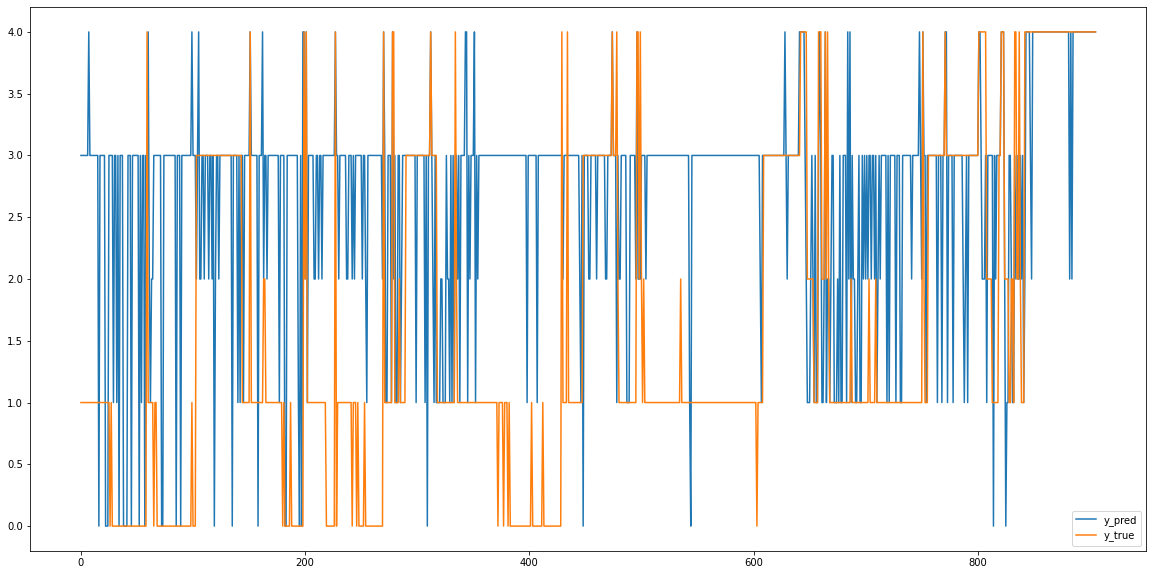

In [68]:
rcParams['figure.figsize'] = 20, 10
plt.plot(y_pred, label='y_pred')
plt.plot(y_true, label='y_true')
plt.legend()
plt.savefig("ss_png.png")

In [69]:
sum(y_pred == y_true) / y_pred.shape[0]

0.32891832229580575